In [1]:
from numpy.random import seed
seed(3)
from tensorflow import set_random_seed
set_random_seed(3)

#You can find the answer at Keras docs: https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development.

#In short, to be absolutely sure that you will get reproducible results with your python script on one computer's/laptop's CPU then you will have to do the following:

#Set PYTHONHASHSEED environment variable at a fixed value
#Set python built-in pseudo-random generator at a fixed value
#Set numpy pseudo-random generator at a fixed value
#Set tensorflow pseudo-random generator at a fixed value
#Configure a new global tensorflow session
#Following the Keras link at the top, the source code I am using is the following:

# Seed value
# Apparently you may use different seed values at each stage
seed_value= 3

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [1]:
import keras
keras.__version__

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


'2.2.0'

# Classifying newswires: a multi-class classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. 
But what happens when you have more than two classes? 

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 2s 1us/step


In [8]:
import os
 
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

current directory is : /root/mount
Directory name is : mount


In [25]:
import pandas as pd
df = pd.read_csv ('produtos.csv')   #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45280 entries, 0 to 45279
Data columns (total 22 columns):
id_loja            45280 non-null int64
ean                45280 non-null int64
sku                45280 non-null int64
descricao          45280 non-null object
status             45280 non-null object
id_departamento    45280 non-null int64
id_categoria       45280 non-null int64
id_marca           45280 non-null int64
id_modelo          45280 non-null int64
id_atributo        11107 non-null float64
preco_min          41330 non-null float64
preco_max          41330 non-null float64
custo              41120 non-null float64
data_cadastro      45280 non-null object
lista              45280 non-null object
frete              41120 non-null object
id                 45280 non-null int64
descricao.1        45280 non-null object
id.1               45280 non-null int64
descricao.2        45280 non-null object
id.2               45280 non-null int64
descricao.3        45280 non-null ob

# Shuffle the dataframe:

In [62]:
df=df.sample(frac=1) #Shuffle the dataframe

In [63]:
df[["descricao","id_departamento"]].head(3)

,descricao,id_departamento
34803,SOFA – CAMA SIMBAL KATANYA PREMIER EM CHENILLE,99
28052,P60 LIGA DA JUSTICA FILME,114
28996,PANELEIRO QUADRI ACO 6 PTS VDR BR/VM CASAMOB,99


In [123]:
X=df[["descricao"]]
y=df[["id_departamento"]]

# Vetorizando os Xs:

In [124]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
print(type(X))
print(len(X))
VectorizedCorpus = vectorizer.fit_transform(X.descricao)
print(len(vectorizer.get_feature_names()))
print(VectorizedCorpus.toarray().shape)
print(VectorizedCorpus.toarray())

<class 'pandas.core.frame.DataFrame'>
45280
26311
(45280, 26311)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [46]:
del(X2)

# Vetorizando os Ys:

In [125]:
from keras.utils.np_utils import to_categorical

Vectorized_y = to_categorical(y)


In [175]:
Vectorized_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [126]:
Vectorized_y.shape

(45280, 139)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

In [127]:
len(train_data)

8982

In [128]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [129]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [130]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [72]:
type(reverse_word_index)

dict

In [73]:
reverse_word_index.get(1)

'the'

In [74]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [131]:
train_labels[10]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [132]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

In [133]:
x_train[1]

array([0., 1., 1., ..., 0., 0., 0.])

In [134]:
len(x_train[2])

10000


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" 
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 
For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1. 
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [135]:
def to_one_hot(labels, dimension=139):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [136]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to 
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the 
dimensionality of the output space is much larger. 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. 
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each 
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, 
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

# Primeira rede: 2 camadas densas de 64 com Softmax:

In [188]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(26311,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(139, activation='softmax'))


There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [189]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [139]:
VectorizedCorpus.shape

(45280, 26311)

In [140]:
VectorizedCorpus[:3]

<3x26311 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

# Criando o  Training, Validation e Test Sets:

In [392]:
x_val = VectorizedCorpus[:2000]
partial_x_train = VectorizedCorpus[2000:]
x_test = x_val[:1000]
x_val = x_val[1000:]

y_val = Vectorized_y[:2000]
partial_y_train = Vectorized_y[2000:]
y_test=y_val[:1000]
y_val=y_val[1000:]

In [177]:
train, validate, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

In [178]:
del(train, validate, test)

In [179]:
print(x_test.shape,y_test.shape,x_val.shape,y_val.shape,partial_x_train.shape, partial_y_train.shape)


(1000, 26311) (1000, 139) (1000, 26311) (1000, 139) (43280, 26311) (43280, 139)


In [167]:
y_val.shape

(1000, 139)

Now let's train our network for 20 epochs:

In [190]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 8s 182us/step - loss: 2.4179 - acc: 0.5457 - val_loss: 1.1233 - val_acc: 0.7100
Epoch 2/20
43280/43280 [==============================] - 8s 175us/step - loss: 0.6657 - acc: 0.8601 - val_loss: 0.4476 - val_acc: 0.9090
Epoch 3/20
43280/43280 [==============================] - 8s 177us/step - loss: 0.2611 - acc: 0.9486 - val_loss: 0.2592 - val_acc: 0.9360
Epoch 4/20
43280/43280 [==============================] - 8s 189us/step - loss: 0.1485 - acc: 0.9664 - val_loss: 0.1960 - val_acc: 0.9550
Epoch 5/20
43280/43280 [==============================] - 9s 201us/step - loss: 0.1017 - acc: 0.9759 - val_loss: 0.1591 - val_acc: 0.9620
Epoch 6/20
43280/43280 [==============================] - 9s 202us/step - loss: 0.0750 - acc: 0.9813 - val_loss: 0.1442 - val_acc: 0.9640
Epoch 7/20
43280/43280 [==============================] - 9s 201us/step - loss: 0.0581 - acc: 0.9852 - val_loss: 0.1328 - v

# Resultados Primeira rede: 2 camadas densas de 64 com Softmax:

Let's display its loss and accuracy curves:

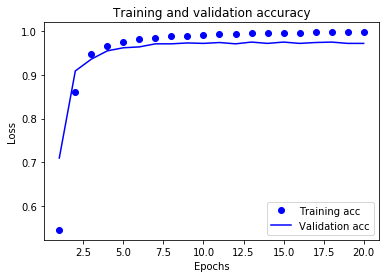

In [191]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

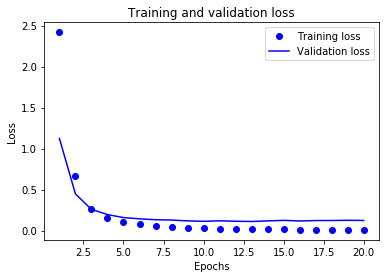

In [192]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Acurácia Máxima atingida:

In [198]:
print(val_acc.index(max(val_acc)))
val_acc[val_acc.index(max(val_acc))]

12


0.9750000081062317

In [ ]:
# Rodando o modela para o número de epocs da accurácia máxima

In [199]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(26311,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(139, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=val_acc.index(max(val_acc)),
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/12
43280/43280 [==============================] - 8s 187us/step - loss: 2.3004 - acc: 0.5331 - val_loss: 1.1437 - val_acc: 0.6970
Epoch 2/12
43280/43280 [==============================] - 8s 176us/step - loss: 0.6640 - acc: 0.8655 - val_loss: 0.4414 - val_acc: 0.9120
Epoch 3/12
43280/43280 [==============================] - 8s 177us/step - loss: 0.2568 - acc: 0.9496 - val_loss: 0.2499 - val_acc: 0.9350
Epoch 4/12
43280/43280 [==============================] - 8s 191us/step - loss: 0.1451 - acc: 0.9670 - val_loss: 0.1860 - val_acc: 0.9510
Epoch 5/12
43280/43280 [==============================] - 9s 207us/step - loss: 0.0984 - acc: 0.9759 - val_loss: 0.1545 - val_acc: 0.9610
Epoch 6/12
43280/43280 [==============================] - 9s 203us/step - loss: 0.0721 - acc: 0.9820 - val_loss: 0.1338 - val_acc: 0.9710
Epoch 7/12
43280/43280 [==============================] - 9s 199us/step - loss: 0.0546 - acc: 0.9860 - val_loss: 0.1188 - v

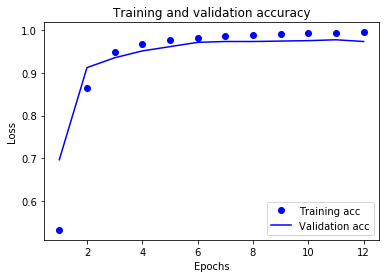

In [200]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## It seems that the network starts overfitting after 12 epochs. Let's train a new network from scratch for 12 epochs, then let's evaluate it on the test set:

In [202]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(26311,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=12,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/12
43280/43280 [==============================] - 8s 184us/step - loss: 2.4312 - acc: 0.5590 - val_loss: 1.1647 - val_acc: 0.7090
Epoch 2/12
43280/43280 [==============================] - 8s 173us/step - loss: 0.6805 - acc: 0.8715 - val_loss: 0.4429 - val_acc: 0.9150
Epoch 3/12
43280/43280 [==============================] - 8s 176us/step - loss: 0.2584 - acc: 0.9496 - val_loss: 0.2457 - val_acc: 0.9420
Epoch 4/12
43280/43280 [==============================] - 8s 185us/step - loss: 0.1449 - acc: 0.9678 - val_loss: 0.1914 - val_acc: 0.9530
Epoch 5/12
43280/43280 [==============================] - 9s 205us/step - loss: 0.0989 - acc: 0.9760 - val_loss: 0.1623 - val_acc: 0.9590
Epoch 6/12
43280/43280 [==============================] - 9s 200us/step - loss: 0.0733 - acc: 0.9818 - val_loss: 0.1424 - val_acc: 0.9670
Epoch 7/12
43280/43280 [==============================] - 9s 201us/step - loss: 0.0560 - acc: 0.9859 - val_loss: 0.1315 - v

### Val_acc máximo ocorreu na epoch 9 dessa vez.  Investigar porque.

In [203]:
results = model.evaluate(x_test, y_test)

1000/1000 [==============================] - 0s 207us/step


In [0]:
?model.evaluate
#Returns the loss value & metrics values for the model in test mode.

In [204]:
results

[0.10720048744249652, 0.971]


Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [206]:
import copy

test_labels_copy = copy.copy(y_test)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(y_test) == np.array(test_labels_copy))) / len(y_test)

137.574

# Passando as camadas densas para 128:

In [205]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(26311,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=15,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/15
43280/43280 [==============================] - 11s 257us/step - loss: 1.6423 - acc: 0.6768 - val_loss: 0.5932 - val_acc: 0.8800
Epoch 2/15
43280/43280 [==============================] - 11s 254us/step - loss: 0.2873 - acc: 0.9456 - val_loss: 0.2307 - val_acc: 0.9430
Epoch 3/15
43280/43280 [==============================] - 12s 269us/step - loss: 0.1260 - acc: 0.9703 - val_loss: 0.1603 - val_acc: 0.9600
Epoch 4/15
43280/43280 [==============================] - 12s 279us/step - loss: 0.0776 - acc: 0.9804 - val_loss: 0.1277 - val_acc: 0.9700
Epoch 5/15
43280/43280 [==============================] - 12s 276us/step - loss: 0.0528 - acc: 0.9867 - val_loss: 0.1115 - val_acc: 0.9720
Epoch 6/15
43280/43280 [==============================] - 12s 277us/step - loss: 0.0386 - acc: 0.9901 - val_loss: 0.1038 - val_acc: 0.9780
Epoch 7/15
43280/43280 [==============================] - 12s 278us/step - loss: 0.0295 - acc: 0.9924 - val_loss: 0.0

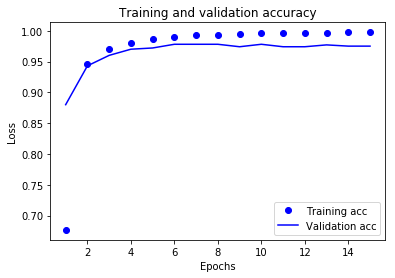

In [207]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Acurácia Máxima atingida com camadas densas de 128:

In [209]:
print(val_acc.index(max(val_acc)))
val_acc[val_acc.index(max(val_acc))]

5


0.9779999899864197

### Foi maior que as camadas de 64, porém o modelo tem que ser retreinado com 5 epocs

In [208]:
results = model.evaluate(x_test, y_test)
results

1000/1000 [==============================] - 0s 329us/step


[0.1367242135230572, 0.967]

In [218]:
max(val_acc)

0.9779999899864197

In [219]:
val_acc

[0.8800000023841857,
 0.9430000114440918,
 0.9599999861717224,
 0.9699999947547913,
 0.9720000081062317,
 0.9779999899864197,
 0.9779999899864197,
 0.9779999876022338,
 0.9740000057220459,
 0.9779999876022338,
 0.9739999923706054,
 0.9740000081062317,
 0.9769999899864197,
 0.9749999923706054,
 0.9750000057220459]

In [220]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(26311,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=val_acc.index(max(val_acc))+1,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/6
43280/43280 [==============================] - 11s 260us/step - loss: 1.6765 - acc: 0.6733 - val_loss: 0.6013 - val_acc: 0.8800
Epoch 2/6
43280/43280 [==============================] - 11s 256us/step - loss: 0.2931 - acc: 0.9438 - val_loss: 0.2306 - val_acc: 0.9410
Epoch 3/6
43280/43280 [==============================] - 12s 270us/step - loss: 0.1258 - acc: 0.9701 - val_loss: 0.1567 - val_acc: 0.9640
Epoch 4/6
43280/43280 [==============================] - 12s 279us/step - loss: 0.0766 - acc: 0.9811 - val_loss: 0.1314 - val_acc: 0.9670
Epoch 5/6
43280/43280 [==============================] - 12s 278us/step - loss: 0.0529 - acc: 0.9865 - val_loss: 0.1161 - val_acc: 0.9710
Epoch 6/6
43280/43280 [==============================] - 12s 279us/step - loss: 0.0387 - acc: 0.9898 - val_loss: 0.1136 - val_acc: 0.9740


In [222]:
print(val_acc.index(max(val_acc))+1)
val_acc[val_acc.index(max(val_acc))]

6


0.9779999899864197

In [223]:
results = model.evaluate(x_test, y_test)
results

1000/1000 [==============================] - 0s 339us/step


[0.10290697045044363, 0.971]

### A loss deu um pouco menor que a de 64 camadas

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic 
predictions for all of the test data:

In [224]:
predictions = model.predict(x_test)

In [225]:
predictions[0]

array([2.43654244e-19, 3.87187037e-19, 7.57370136e-19, 4.02325244e-19,
       1.60450291e-18, 2.86497521e-19, 1.46595202e-18, 2.93367721e-19,
       3.46852521e-19, 1.10000566e-18, 5.72727604e-19, 1.56283214e-19,
       4.72469901e-19, 2.55456586e-19, 6.12076947e-20, 2.43335774e-18,
       1.13779769e-18, 2.99855376e-19, 3.74752393e-19, 2.24875331e-19,
       1.07413476e-18, 7.35077102e-19, 5.77413375e-19, 9.92915968e-19,
       1.66296090e-18, 1.49674183e-19, 5.80625007e-19, 1.55471556e-19,
       4.91167285e-19, 4.21350269e-19, 1.55368998e-19, 9.70714091e-20,
       7.27062135e-19, 3.69303056e-18, 4.94902522e-19, 6.20746782e-19,
       1.00186844e-18, 5.42845756e-19, 7.45352339e-19, 3.79528911e-18,
       3.84075727e-19, 2.51087728e-19, 4.00590336e-18, 1.13627081e-18,
       2.99682862e-18, 1.81040846e-19, 1.10780877e-18, 1.86112006e-19,
       3.16913417e-19, 5.33466251e-19, 4.91859170e-19, 1.53501571e-18,
       4.64239092e-19, 2.59544771e-19, 3.12411207e-18, 6.94885274e-19,
      

Each entry in `predictions` is a vector of length 139:

In [107]:
predictions[0].shape

(139,)

The coefficients in this vector sum to 1:

In [226]:
np.sum(predictions[0])

1.0

The largest entry is the predicted class, i.e. the class with the highest probability:

In [227]:
np.argmax(predictions[0])

99

## A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like such:

In [68]:
train_labels[9]

16

In [0]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [70]:
y_train[9]

16


The only thing it would change is the choice of the loss function. Our previous loss, `categorical_crossentropy`, expects the labels to 
follow a categorical encoding. With integer labels, we should use `sparse_categorical_crossentropy`:

# Mudando o modelo para prever o código do departamento com sparse_categorical_crossentropy:

In [231]:
y.head(2)

,id_departamento
34803,99
28052,114


In [233]:
y_val = np.array(y[:2000])
partial_y_train = np.array(y[2000:])
y_test=y_val[:1000]
y_val=y_val[1000:]

In [240]:
print(partial_y_train[0:2])
print(y_test[0:2])
print(y_val[0:2])

[[ 99]
 [113]]
[[ 99]
 [114]]
[[112]
 [ 99]]


In [237]:
partial_x_train

<43280x26311 sparse matrix of type '<class 'numpy.int64'>'
	with 298087 stored elements in Compressed Sparse Row format>

In [238]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(26311,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 8s 186us/step - loss: 2.3798 - acc: 0.5411 - val_loss: 1.1486 - val_acc: 0.7410
Epoch 2/20
43280/43280 [==============================] - 7s 170us/step - loss: 0.6696 - acc: 0.8729 - val_loss: 0.4463 - val_acc: 0.9140
Epoch 3/20
43280/43280 [==============================] - 7s 170us/step - loss: 0.2589 - acc: 0.9485 - val_loss: 0.2571 - val_acc: 0.9400
Epoch 4/20
43280/43280 [==============================] - 7s 171us/step - loss: 0.1496 - acc: 0.9658 - val_loss: 0.1949 - val_acc: 0.9520
Epoch 5/20
43280/43280 [==============================] - 8s 190us/step - loss: 0.1025 - acc: 0.9748 - val_loss: 0.1599 - val_acc: 0.9600
Epoch 6/20
43280/43280 [==============================] - 8s 192us/step - loss: 0.0755 - acc: 0.9815 - val_loss: 0.1410 - val_acc: 0.9640
Epoch 7/20
43280/43280 [==============================] - 9s 199us/step - loss: 0.0578 - acc: 0.9856 - val_loss: 0.1277 - v

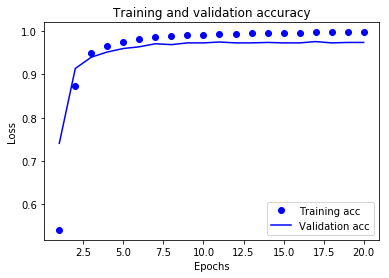

In [239]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface.

In [244]:
print(val_acc.index(max(val_acc))+1)
val_acc[val_acc.index(max(val_acc))]

17


0.9759999899864197

In [245]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(26311,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=val_acc.index(max(val_acc))+1,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/17
43280/43280 [==============================] - 9s 201us/step - loss: 2.4429 - acc: 0.5570 - val_loss: 1.1247 - val_acc: 0.7240
Epoch 2/17
43280/43280 [==============================] - 9s 207us/step - loss: 0.6565 - acc: 0.8675 - val_loss: 0.4602 - val_acc: 0.9070
Epoch 3/17
43280/43280 [==============================] - 8s 189us/step - loss: 0.2633 - acc: 0.9484 - val_loss: 0.2669 - val_acc: 0.9320
Epoch 4/17
43280/43280 [==============================] - 8s 192us/step - loss: 0.1493 - acc: 0.9675 - val_loss: 0.2020 - val_acc: 0.9450
Epoch 5/17
43280/43280 [==============================] - 8s 194us/step - loss: 0.1014 - acc: 0.9757 - val_loss: 0.1650 - val_acc: 0.9560
Epoch 6/17
43280/43280 [==============================] - 9s 210us/step - loss: 0.0746 - acc: 0.9811 - val_loss: 0.1374 - val_acc: 0.9680
Epoch 7/17
43280/43280 [==============================] - 9s 202us/step - loss: 0.0578 - acc: 0.9853 - val_loss: 0.1312 - v

In [246]:
results = model.evaluate(x_test, y_test)
results

1000/1000 [==============================] - 0s 235us/step


[0.11445237646039459, 0.969]

### O melhor resultado foi com layer de 64 e y-> one hot enconded.  Voltando para essa configuração:

# Usando Word embeddings:

In [253]:
VectorizedCorpus.shape

(45280, 26311)

In [349]:
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)
from keras import preprocessing
max_vocab_len = 26469 #max_features
max_description_len = 100 #maxlen

#analyzer = vectorizer.build_analyzer()
#output_corpus = [list(map(lambda x: vectorizer.vocabulary_.get(x), analyzer(line))) for line in X.descricao]

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 26469)
tokenizer.fit_on_texts(X.descricao)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X.descricao)

In [350]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 26469 unique tokens.


In [367]:
word_index

{'de': 1,
 'br': 2,
 'com': 3,
 'branco': 4,
 'e': 5,
 'preto': 6,
 'c': 7,
 '2': 8,
 'vvc': 9,
 '3': 10,
 'sofa': 11,
 'pr': 12,
 'mesa': 13,
 '1': 14,
 'col': 15,
 'para': 16,
 'tramontina': 17,
 '220v': 18,
 'p': 19,
 '4': 20,
 'moveis': 21,
 'cama': 22,
 'casal': 23,
 'cadeira': 24,
 'inox': 25,
 'box': 26,
 'painel': 27,
 '6': 28,
 'em': 29,
 'cinza': 30,
 'rack': 31,
 'kit': 32,
 'fios': 33,
 'azul': 34,
 'cm': 35,
 '127v': 36,
 'bege': 37,
 'portas': 38,
 'armario': 39,
 'suede': 40,
 'pt': 41,
 'plus': 42,
 'home': 43,
 'balcao': 44,
 'a': 45,
 'kappesberg': 46,
 'colchao': 47,
 'porta': 48,
 'brinox': 49,
 '110v': 50,
 'queen': 51,
 'x': 52,
 'tv': 53,
 '5': 54,
 'premium': 55,
 'poltrona': 56,
 'comoda': 57,
 'bartira': 58,
 'pecas': 59,
 'gavetas': 60,
 'jogo': 61,
 'marrom': 62,
 'cad': 63,
 'arm': 64,
 'solteiro': 65,
 'cz': 66,
 'conj': 67,
 '–': 68,
 'linoforte': 69,
 'vm': 70,
 'cel': 71,
 'az': 72,
 'plumasul': 73,
 '3l': 74,
 'pcs': 75,
 'desb': 76,
 'philco': 77,
 '2

In [352]:
sequences

[[11, 68, 22, 110, 7672, 1352, 29, 321],
 [2605, 2606, 192, 2491, 1867],
 [191, 841, 106, 28, 150, 2883, 2, 70, 610],
 [109, 28, 654, 413, 5039, 9391, 551, 403],
 [372, 45, 19, 6419, 811, 18, 2, 2884],
 [57, 5040, 2730, 2, 1255, 21],
 [5, 99, 91, 326, 1031, 119, 228],
 [151, 3, 1210, 23, 13522, 73, 166, 33],
 [57, 58, 2885, 3, 20, 60, 5, 8, 347],
 [1256, 296, 611, 9392, 2, 36, 144],
 [128, 3204, 23, 13523, 315, 1365, 110],
 [5, 131, 4197, 824, 542, 230, 281, 534],
 [67, 8, 146, 1211, 216, 215, 217],
 [558, 179, 1313, 4582, 9393, 1366, 50, 101],
 [22, 26, 67, 2731, 129, 361, 14, 2732, 3205, 655, 45],
 [316, 25, 9394, 28, 921],
 [2492, 3418, 85, 72, 460, 13524, 1080],
 [9, 31, 43, 3419, 165, 12, 221],
 [61, 1, 3888, 693, 193, 75, 17, 156],
 [13, 5623, 656, 157, 84],
 [9, 11, 74, 105, 607, 885, 472],
 [259, 518, 5624, 3889, 89, 14, 535, 2493],
 [636, 1032, 7, 2733, 13525, 117],
 [402, 1124, 6420, 13526, 274, 1314, 18, 328],
 [31, 3043, 9395, 216, 612, 613],
 [1656, 529, 403, 13527, 461, 6

In [353]:
output_corpus

NameError: name 'output_corpus' is not defined

In [269]:
del(output_corpus)

In [354]:
sequences = preprocessing.sequence.pad_sequences(sequences, maxlen=max_description_len)

In [355]:
sequences

array([[    0,     0,     0, ...,  1352,    29,   321],
       [    0,     0,     0, ...,   192,  2491,  1867],
       [    0,     0,     0, ...,     2,    70,   610],
       ...,
       [    0,     0,     0, ...,   452,     2,   107],
       [    0,     0,     0, ..., 10948,    50,   101],
       [    0,     0,     0, ...,   468,   230,   186]], dtype=int32)

In [394]:
x_val = sequences[:2000]
partial_x_train = sequences[2000:]
x_test = x_val[:1000]
x_val = x_val[1000:]

y_val = Vectorized_y[:2000]
partial_y_train = Vectorized_y[2000:]
y_test=y_val[:1000]
y_val=y_val[1000:]

# Melhor resultado foi esse com uma Embedding layer:

In [357]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Embedding(max_vocab_len, 150, input_length=max_description_len))
model.add(Flatten())
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val))


Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 12s 267us/step - loss: 1.7391 - acc: 0.5561 - val_loss: 1.1716 - val_acc: 0.7350
Epoch 2/20
43280/43280 [==============================] - 10s 229us/step - loss: 0.7359 - acc: 0.8351 - val_loss: 0.5578 - val_acc: 0.8780
Epoch 3/20
43280/43280 [==============================] - 10s 231us/step - loss: 0.3369 - acc: 0.9317 - val_loss: 0.3208 - val_acc: 0.9240
Epoch 4/20
43280/43280 [==============================] - 11s 247us/step - loss: 0.1850 - acc: 0.9593 - val_loss: 0.2345 - val_acc: 0.9380
Epoch 5/20
43280/43280 [==============================] - 10s 239us/step - loss: 0.1188 - acc: 0.9728 - val_loss: 0.1853 - val_acc: 0.9560
Epoch 6/20
43280/43280 [==============================] - 11s 247us/step - loss: 0.0829 - acc: 0.9808 - val_loss: 0.1541 - val_acc: 0.9520
Epoch 7/20
43280/43280 [==============================] - 10s 236us/step - loss: 0.0603 - acc: 0.9851 - val_loss: 0.1

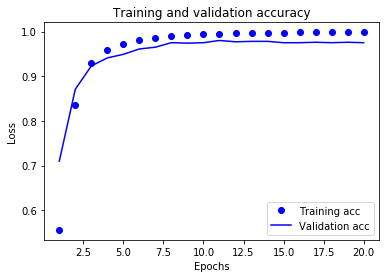

In [312]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [313]:
print(val_acc.index(max(val_acc))+1)
val_acc[val_acc.index(max(val_acc))]

11


0.9800000033378601

In [358]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Embedding(max_vocab_len, 150, input_length=max_description_len))
model.add(Flatten())
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=11,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/11
43280/43280 [==============================] - 11s 262us/step - loss: 1.7472 - acc: 0.5533 - val_loss: 1.1685 - val_acc: 0.7130
Epoch 2/11
43280/43280 [==============================] - 10s 227us/step - loss: 0.7379 - acc: 0.8336 - val_loss: 0.5581 - val_acc: 0.8790
Epoch 3/11
43280/43280 [==============================] - 10s 242us/step - loss: 0.3388 - acc: 0.9305 - val_loss: 0.3251 - val_acc: 0.9240
Epoch 4/11
43280/43280 [==============================] - 10s 240us/step - loss: 0.1856 - acc: 0.9597 - val_loss: 0.2346 - val_acc: 0.9350
Epoch 5/11
43280/43280 [==============================] - 10s 225us/step - loss: 0.1189 - acc: 0.9729 - val_loss: 0.1802 - val_acc: 0.9580
Epoch 6/11
43280/43280 [==============================] - 10s 237us/step - loss: 0.0827 - acc: 0.9801 - val_loss: 0.1569 - val_acc: 0.9570
Epoch 7/11
43280/43280 [==============================] - 10s 238us/step - loss: 0.0601 - acc: 0.9858 - val_loss: 0.1

In [319]:
results = model.evaluate(x_test, y_test)
results

1000/1000 [==============================] - 0s 214us/step


[0.08108938695245888, 0.976]

In [320]:
predictions = model.predict(x_test)

In [321]:
np.sum(predictions[0])

1.0000001

In [348]:
np.argmax(predictions[0])

99

# Criando um Mapa 2D

In [372]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Embedding(max_vocab_len, 2, input_length=max_description_len))
model.add(Flatten())
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=185,
          batch_size=512,
          validation_data=(x_val, y_val))
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

Train on 43280 samples, validate on 1000 samples
Epoch 1/185
43280/43280 [==============================] - 2s 52us/step - loss: 3.6627 - acc: 0.4352 - val_loss: 2.4946 - val_acc: 0.4760
Epoch 2/185
43280/43280 [==============================] - 1s 19us/step - loss: 2.1687 - acc: 0.4924 - val_loss: 2.1435 - val_acc: 0.4760
Epoch 3/185
43280/43280 [==============================] - 1s 20us/step - loss: 2.0053 - acc: 0.4924 - val_loss: 2.0129 - val_acc: 0.4760
Epoch 4/185
43280/43280 [==============================] - 1s 19us/step - loss: 1.8691 - acc: 0.4925 - val_loss: 1.8706 - val_acc: 0.4770
Epoch 5/185
43280/43280 [==============================] - 1s 20us/step - loss: 1.7289 - acc: 0.4991 - val_loss: 1.7309 - val_acc: 0.4980
Epoch 6/185
43280/43280 [==============================] - 1s 21us/step - loss: 1.5975 - acc: 0.5204 - val_loss: 1.6058 - val_acc: 0.5180
Epoch 7/185
43280/43280 [==============================] - 1s 23us/step - loss: 1.4817 - acc: 0.5527 - val_loss: 1.4959 - v

Epoch 118/185
43280/43280 [==============================] - 1s 20us/step - loss: 0.2075 - acc: 0.9483 - val_loss: 0.4616 - val_acc: 0.8830
Epoch 119/185
43280/43280 [==============================] - 1s 20us/step - loss: 0.2062 - acc: 0.9483 - val_loss: 0.4617 - val_acc: 0.8850
Epoch 120/185
43280/43280 [==============================] - 1s 20us/step - loss: 0.2048 - acc: 0.9491 - val_loss: 0.4610 - val_acc: 0.8870
Epoch 121/185
43280/43280 [==============================] - 1s 20us/step - loss: 0.2035 - acc: 0.9496 - val_loss: 0.4617 - val_acc: 0.8850
Epoch 122/185
43280/43280 [==============================] - 1s 20us/step - loss: 0.2024 - acc: 0.9499 - val_loss: 0.4614 - val_acc: 0.8860
Epoch 123/185
43280/43280 [==============================] - 1s 22us/step - loss: 0.2012 - acc: 0.9505 - val_loss: 0.4602 - val_acc: 0.8840
Epoch 124/185
43280/43280 [==============================] - 1s 21us/step - loss: 0.1999 - acc: 0.9507 - val_loss: 0.4613 - val_acc: 0.8860
Epoch 125/185
43280/

In [373]:
w2v_df = pd.DataFrame(weights, columns = ['x1', 'x2'])
w2v_df['word'] = word_index.keys()
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,de,-0.168053,-0.000519
1,br,-0.097127,0.289995
2,com,-0.042599,-0.243490
3,branco,-0.357370,-0.294611
4,e,0.007783,-0.464789
5,preto,-0.245619,-0.001759
6,c,0.407861,-0.149993
7,2,-0.284485,-0.069304
8,vvc,-0.099789,-0.070928
9,3,-1.033792,-1.158080


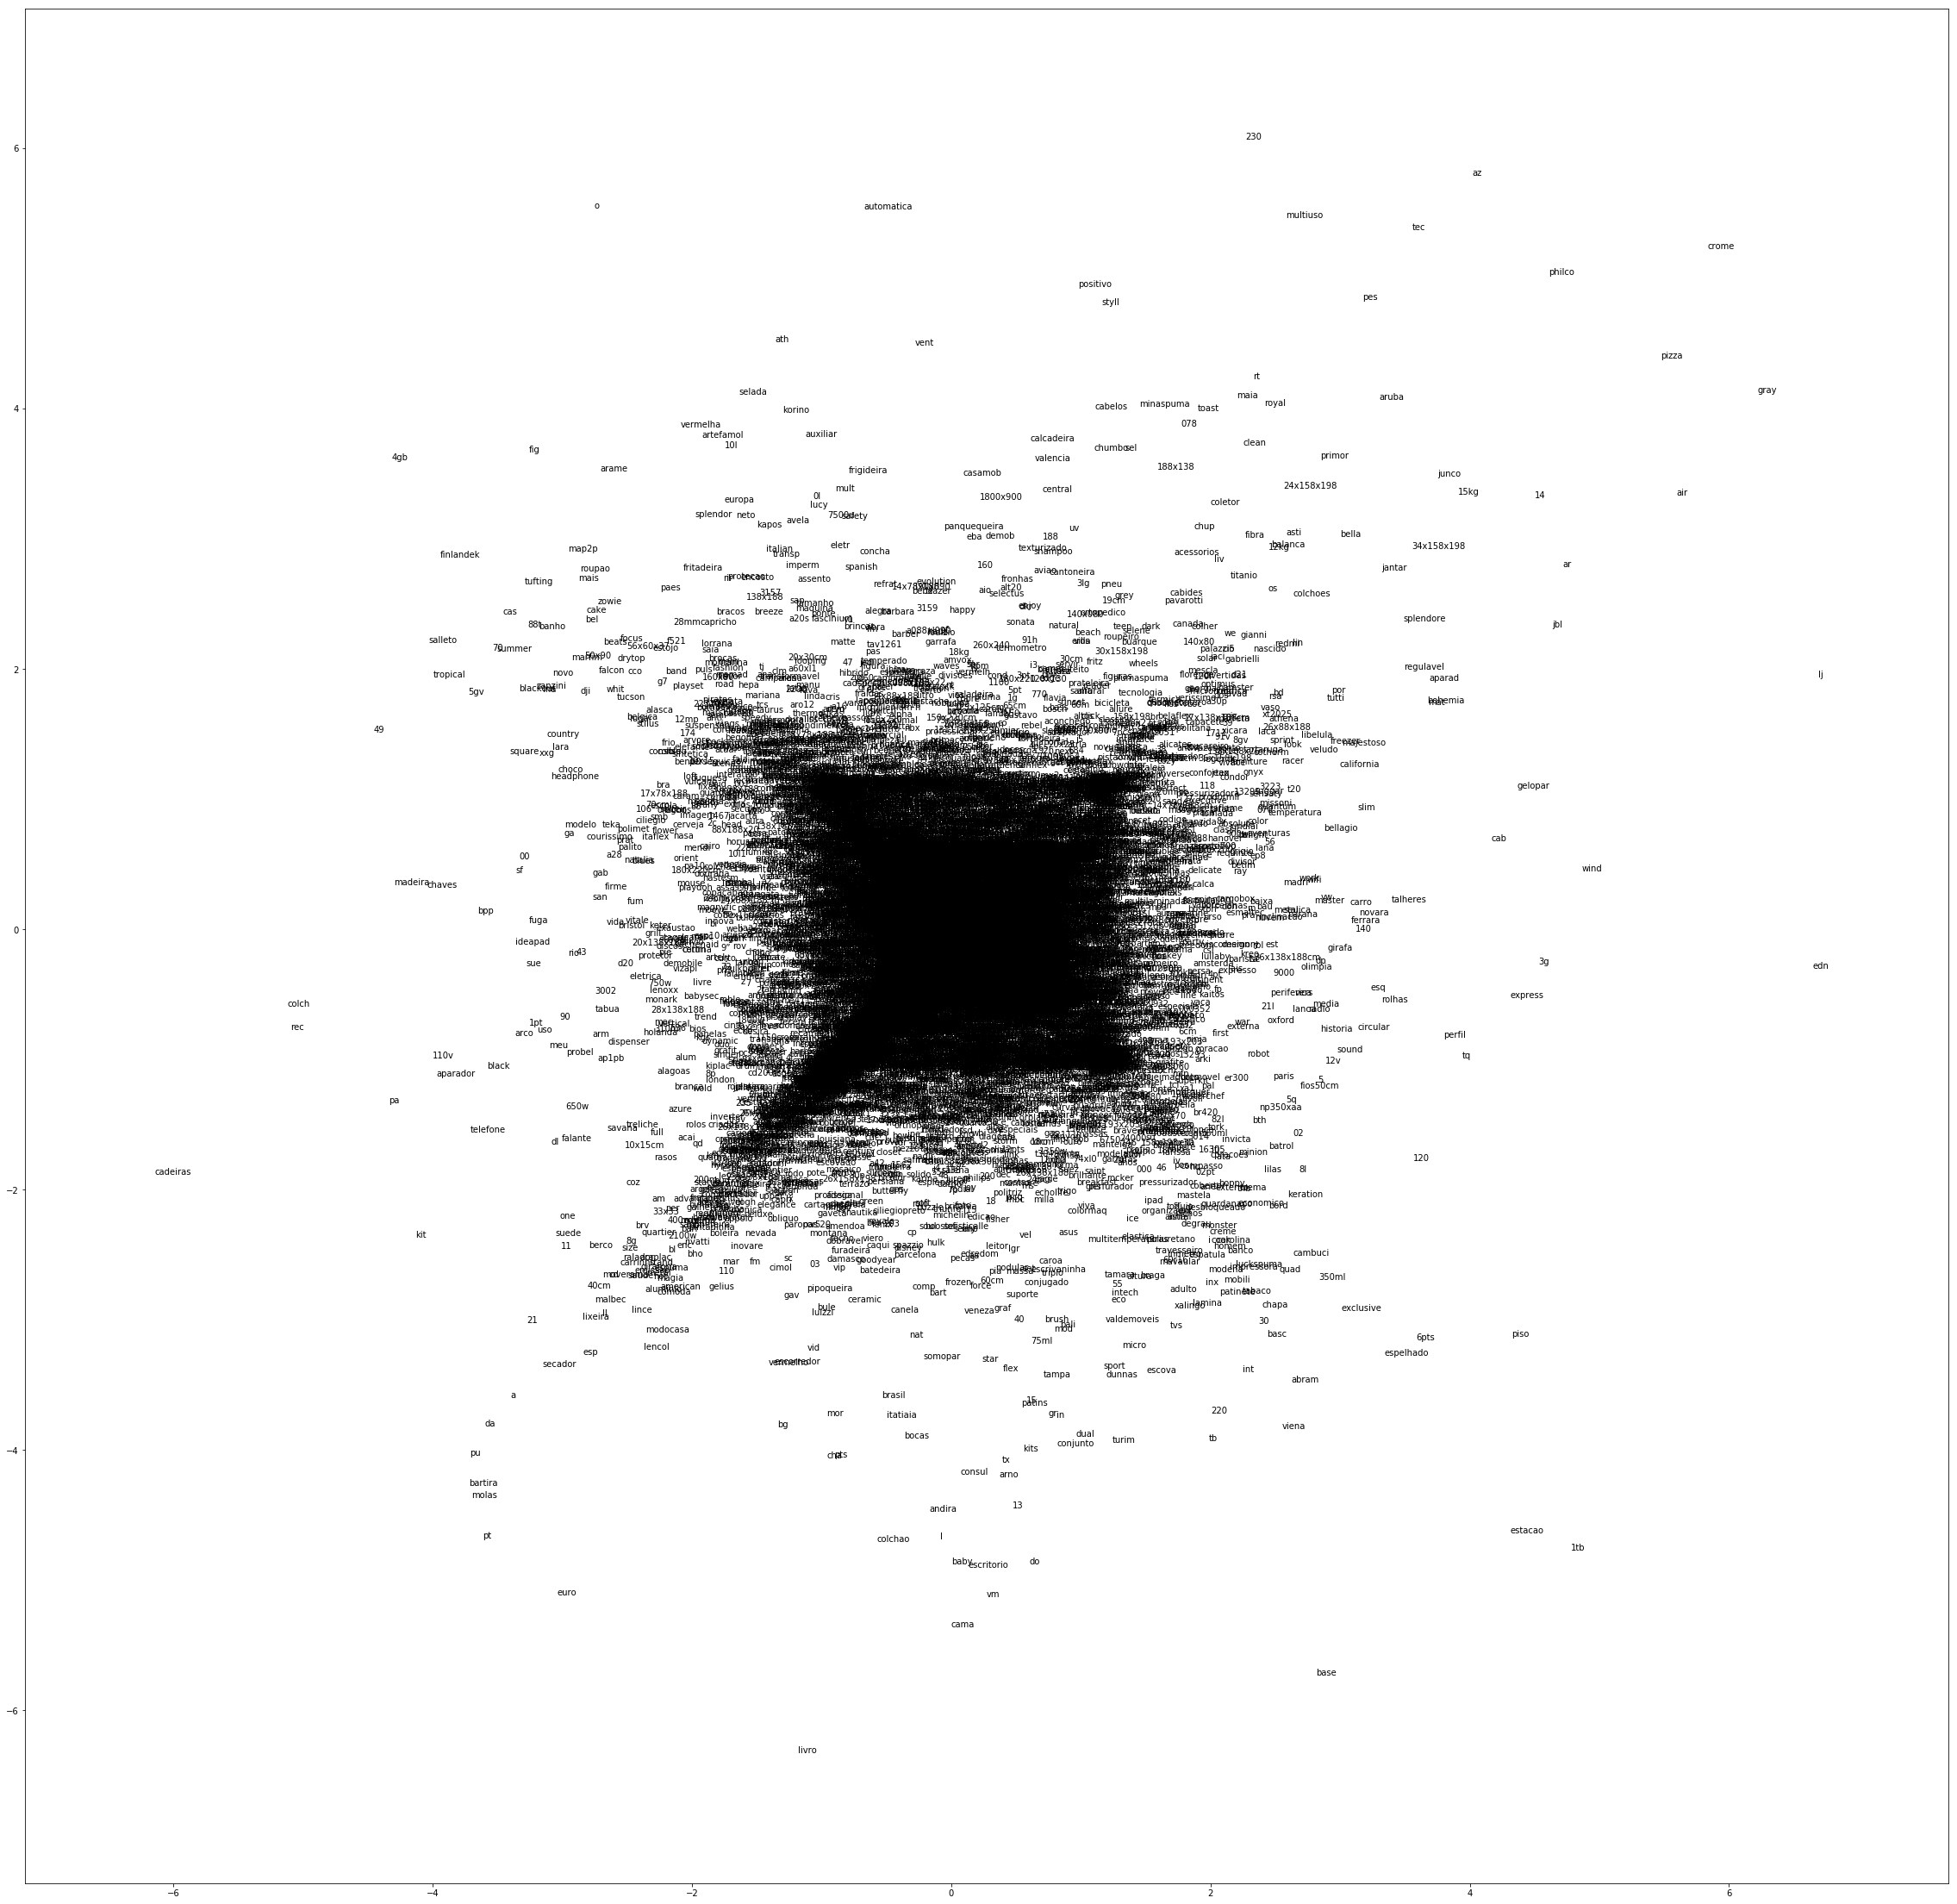

In [374]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(weights, axis=0)[0] - PADDING
y_axis_min = np.amin(weights, axis=0)[1] - PADDING
x_axis_max = np.amax(weights, axis=0)[0] + PADDING
y_axis_max = np.amax(weights, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (40,40)

plt.show()

In [381]:
import io

#encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word, x1, x2 in zip(range(len(w2v_df['x1'])),w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
#for num, word in enumerate(encoder.subwords):
  vec = weights[num] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [382]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Embedding(max_vocab_len, 3, input_length=max_description_len))
model.add(Flatten())
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=180,
          batch_size=512,
          validation_data=(x_val, y_val))
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


Train on 43280 samples, validate on 1000 samples
Epoch 1/180
43280/43280 [==============================] - 2s 55us/step - loss: 3.3610 - acc: 0.2437 - val_loss: 2.2769 - val_acc: 0.4760
Epoch 2/180
43280/43280 [==============================] - 1s 17us/step - loss: 2.0945 - acc: 0.4924 - val_loss: 2.0931 - val_acc: 0.4760
Epoch 3/180
43280/43280 [==============================] - 1s 17us/step - loss: 1.9363 - acc: 0.4924 - val_loss: 1.9276 - val_acc: 0.4760
Epoch 4/180
43280/43280 [==============================] - 1s 17us/step - loss: 1.7629 - acc: 0.4932 - val_loss: 1.7458 - val_acc: 0.4780
Epoch 5/180
43280/43280 [==============================] - 1s 17us/step - loss: 1.5866 - acc: 0.5193 - val_loss: 1.5799 - val_acc: 0.5400
Epoch 6/180
43280/43280 [==============================] - 1s 17us/step - loss: 1.4260 - acc: 0.5890 - val_loss: 1.4319 - val_acc: 0.6000
Epoch 7/180
43280/43280 [==============================] - 1s 17us/step - loss: 1.2858 - acc: 0.6629 - val_loss: 1.3048 - v

Epoch 118/180
43280/43280 [==============================] - 1s 22us/step - loss: 0.0713 - acc: 0.9838 - val_loss: 0.2920 - val_acc: 0.9260
Epoch 119/180
43280/43280 [==============================] - 1s 22us/step - loss: 0.0705 - acc: 0.9839 - val_loss: 0.2922 - val_acc: 0.9270
Epoch 120/180
43280/43280 [==============================] - 1s 19us/step - loss: 0.0695 - acc: 0.9841 - val_loss: 0.2929 - val_acc: 0.9250
Epoch 121/180
43280/43280 [==============================] - 1s 19us/step - loss: 0.0690 - acc: 0.9841 - val_loss: 0.2930 - val_acc: 0.9260
Epoch 122/180
43280/43280 [==============================] - 1s 22us/step - loss: 0.0682 - acc: 0.9844 - val_loss: 0.2936 - val_acc: 0.9260
Epoch 123/180
43280/43280 [==============================] - 1s 23us/step - loss: 0.0674 - acc: 0.9847 - val_loss: 0.2938 - val_acc: 0.9240
Epoch 124/180
43280/43280 [==============================] - 1s 24us/step - loss: 0.0666 - acc: 0.9848 - val_loss: 0.2932 - val_acc: 0.9250
Epoch 125/180
43280/

In [383]:
w2v_df = pd.DataFrame(weights, columns = ['x1', 'x2','x3'])
w2v_df['word'] = word_index.keys()
w2v_df = w2v_df[['word', 'x1', 'x2','x3']]
w2v_df

,word,x1,x2,x3
0,de,0.122755,-0.029964,0.014077
1,br,-0.014632,0.137450,-0.152927
2,com,-0.214830,0.250888,0.168119
3,branco,0.486272,0.096431,0.241468
4,e,-0.090554,0.720071,0.476468
5,preto,-0.185915,0.003138,0.172103
6,c,0.170793,0.393468,-0.029419
7,2,0.026723,-0.043380,-0.018461
8,vvc,-0.309167,-0.018595,-0.149730
9,3,-1.342008,-0.845020,0.781497


In [384]:
import io

#encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word, x1, x2, x3 in zip(range(len(w2v_df['x1'])),w2v_df['word'], w2v_df['x1'], w2v_df['x2'], w2v_df['x3']):
  vec = weights[num] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

# Adding Batch Normalization:

In [347]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import BatchNormalization
model = Sequential()
model.add(Embedding(max_vocab_len, 150, input_length=max_description_len))
model.add(BatchNormalization())
model.add(Flatten())
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 23s 532us/step - loss: 0.7995 - acc: 0.8095 - val_loss: 5.2662 - val_acc: 0.4520
Epoch 2/20
43280/43280 [==============================] - 21s 493us/step - loss: 0.0901 - acc: 0.9777 - val_loss: 9.2163 - val_acc: 0.0720
Epoch 3/20
43280/43280 [==============================] - 21s 497us/step - loss: 0.0273 - acc: 0.9931 - val_loss: 3.3869 - val_acc: 0.6450
Epoch 4/20
43280/43280 [==============================] - 22s 498us/step - loss: 0.0125 - acc: 0.9969 - val_loss: 0.1657 - val_acc: 0.9550
Epoch 5/20
43280/43280 [==============================] - 22s 499us/step - loss: 0.0093 - acc: 0.9974 - val_loss: 0.5436 - val_acc: 0.8940
Epoch 6/20
43280/43280 [==============================] - 22s 499us/step - loss: 0.0079 - acc: 0.9978 - val_loss: 0.1457 - val_acc: 0.9620
Epoch 7/20
43280/43280 [==============================] - 22s 501us/step - loss: 0.0075 - acc: 0.9979 - val_loss: 0.2

In [379]:
range(5)

range(0, 5)

#### Batch Normalization does not seem to improve the results.

# Adding an extra Dense layer:

In [331]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Embedding(max_vocab_len, 150, input_length=max_description_len))
model.add(Flatten())
model.add(Dense(145, activation='relu'))
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 11s 254us/step - loss: 1.6953 - acc: 0.5787 - val_loss: 1.1195 - val_acc: 0.7190
Epoch 2/20
43280/43280 [==============================] - 11s 246us/step - loss: 0.6949 - acc: 0.8311 - val_loss: 0.5431 - val_acc: 0.8640
Epoch 3/20
43280/43280 [==============================] - 11s 249us/step - loss: 0.3089 - acc: 0.9284 - val_loss: 0.3174 - val_acc: 0.9160
Epoch 4/20
43280/43280 [==============================] - 11s 253us/step - loss: 0.1683 - acc: 0.9600 - val_loss: 0.2189 - val_acc: 0.9410
Epoch 5/20
43280/43280 [==============================] - 11s 247us/step - loss: 0.1040 - acc: 0.9754 - val_loss: 0.1729 - val_acc: 0.9600
Epoch 6/20
43280/43280 [==============================] - 11s 245us/step - loss: 0.0695 - acc: 0.9834 - val_loss: 0.1542 - val_acc: 0.9610
Epoch 7/20
43280/43280 [==============================] - 11s 248us/step - loss: 0.0477 - acc: 0.9884 - val_loss: 0.1

#### Adding an extra Dense layer does't seem to help

# Adding a GRU Layer:

In [339]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import GRU
model = Sequential()
model.add(Embedding(max_vocab_len, 150, input_length=max_description_len))
#model.add(Flatten())
model.add(GRU(150))
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=11,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/11
43280/43280 [==============================] - 66s 2ms/step - loss: 1.9375 - acc: 0.5402 - val_loss: 1.3425 - val_acc: 0.6390
Epoch 2/11
43280/43280 [==============================] - 65s 2ms/step - loss: 0.9342 - acc: 0.7598 - val_loss: 0.7124 - val_acc: 0.8090
Epoch 3/11
43280/43280 [==============================] - 64s 1ms/step - loss: 0.4482 - acc: 0.8871 - val_loss: 0.4190 - val_acc: 0.8980
Epoch 4/11
43280/43280 [==============================] - 64s 1ms/step - loss: 0.2473 - acc: 0.9375 - val_loss: 0.2869 - val_acc: 0.9230
Epoch 5/11
43280/43280 [==============================] - 63s 1ms/step - loss: 0.1549 - acc: 0.9604 - val_loss: 0.2559 - val_acc: 0.9320
Epoch 6/11
43280/43280 [==============================] - 64s 1ms/step - loss: 0.1037 - acc: 0.9724 - val_loss: 0.2064 - val_acc: 0.9430
Epoch 7/11
43280/43280 [==============================] - 63s 1ms/step - loss: 0.0732 - acc: 0.9809 - val_loss: 0.1851 - val_acc:

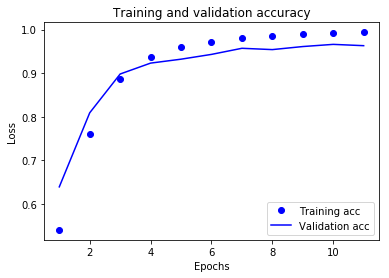

In [340]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Adding Bidirectional LSTM

In [344]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_vocab_len, 150, input_length=max_description_len))
#model.add(Flatten())
model.add(layers.Bidirectional(layers.LSTM(150)))
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=11,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/11
43280/43280 [==============================] - 144s 3ms/step - loss: 1.8927 - acc: 0.5419 - val_loss: 1.4386 - val_acc: 0.5670
Epoch 2/11
43280/43280 [==============================] - 142s 3ms/step - loss: 1.0095 - acc: 0.7301 - val_loss: 0.7250 - val_acc: 0.8160
Epoch 3/11
43280/43280 [==============================] - 142s 3ms/step - loss: 0.5082 - acc: 0.8723 - val_loss: 0.3920 - val_acc: 0.9000
Epoch 4/11
43280/43280 [==============================] - 143s 3ms/step - loss: 0.2477 - acc: 0.9403 - val_loss: 0.2637 - val_acc: 0.9270
Epoch 5/11
43280/43280 [==============================] - 144s 3ms/step - loss: 0.1511 - acc: 0.9593 - val_loss: 0.2544 - val_acc: 0.9290
Epoch 6/11
43280/43280 [==============================] - 146s 3ms/step - loss: 0.1018 - acc: 0.9727 - val_loss: 0.2224 - val_acc: 0.9430
Epoch 7/11
43280/43280 [==============================] - 147s 3ms/step - loss: 0.0738 - acc: 0.9801 - val_loss: 0.1628 - v

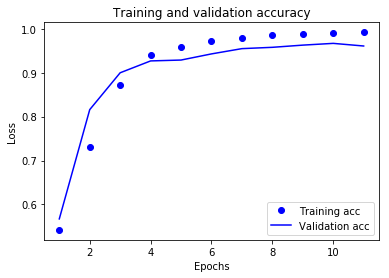

In [345]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Usando Convolution layers:

In [396]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Embedding(max_vocab_len, 150, input_length=max_description_len))
model.add(layers.Conv1D(32, 9, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 9, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer=RMSprop(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

#history = model.fit(x_train, y_train,epochs=20,batch_size=128,validation_split=0.2)

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 36s 823us/step - loss: 3.3690 - acc: 0.4896 - val_loss: 2.6667 - val_acc: 0.4760
Epoch 2/20
43280/43280 [==============================] - 34s 782us/step - loss: 2.3209 - acc: 0.4924 - val_loss: 2.2506 - val_acc: 0.4760
Epoch 3/20
43280/43280 [==============================] - 36s 821us/step - loss: 2.0564 - acc: 0.4924 - val_loss: 2.0074 - val_acc: 0.4760
Epoch 4/20
43280/43280 [==============================] - 34s 795us/step - loss: 1.7890 - acc: 0.5124 - val_loss: 1.7411 - val_acc: 0.5360
Epoch 5/20
43280/43280 [==============================] - 34s 796us/step - loss: 1.5964 - acc: 0.5691 - val_loss: 1.6138 - val_acc: 0.5620
Epoch 6/20
43280/43280 [==============================] - 33s 768us/step - loss: 1.5076 - acc: 0.5972 - val_loss: 1.5366 - val_acc: 0.5820
Epoch 7/20
43280/43280 [==============================] - 36s 834us/step - loss: 1.4372 - acc: 0.6152 - val_loss: 1.4

In [391]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Embedding(max_vocab_len, 150, input_length=max_description_len))
model.add(layers.Conv1D(64, 9, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(64, 9, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer=RMSprop(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

#history = model.fit(x_train, y_train,epochs=20,batch_size=128,validation_split=0.2)

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))


Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 41s 940us/step - loss: 2.7597 - acc: 0.4838 - val_loss: 2.2726 - val_acc: 0.4760
Epoch 2/20
43280/43280 [==============================] - 40s 931us/step - loss: 2.1366 - acc: 0.4924 - val_loss: 2.1428 - val_acc: 0.4760
Epoch 3/20
43280/43280 [==============================] - 41s 947us/step - loss: 1.8898 - acc: 0.4927 - val_loss: 1.7739 - val_acc: 0.4890
Epoch 4/20
43280/43280 [==============================] - 41s 947us/step - loss: 1.5695 - acc: 0.5600 - val_loss: 1.5550 - val_acc: 0.5670
Epoch 5/20
43280/43280 [==============================] - 41s 944us/step - loss: 1.4149 - acc: 0.6142 - val_loss: 1.4242 - val_acc: 0.6100
Epoch 6/20
43280/43280 [==============================] - 44s 1ms/step - loss: 1.2915 - acc: 0.6538 - val_loss: 1.3008 - val_acc: 0.6550
Epoch 7/20
43280/43280 [==============================] - 43s 988us/step - loss: 1.1775 - acc: 0.6832 - val_loss: 1.204

In [398]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Embedding(max_vocab_len, 150, input_length=max_description_len))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer=RMSprop(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

#history = model.fit(x_train, y_train,epochs=20,batch_size=128,validation_split=0.2)

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 59s 1ms/step - loss: 2.4918 - acc: 0.4910 - val_loss: 2.2449 - val_acc: 0.4760
Epoch 2/20
43280/43280 [==============================] - 63s 1ms/step - loss: 2.0418 - acc: 0.4924 - val_loss: 1.8952 - val_acc: 0.4760
Epoch 3/20
43280/43280 [==============================] - 63s 1ms/step - loss: 1.6266 - acc: 0.5532 - val_loss: 1.6023 - val_acc: 0.5570
Epoch 4/20
43280/43280 [==============================] - 62s 1ms/step - loss: 1.4401 - acc: 0.5917 - val_loss: 1.4320 - val_acc: 0.5940
Epoch 5/20
43280/43280 [==============================] - 62s 1ms/step - loss: 1.2951 - acc: 0.6377 - val_loss: 1.2896 - val_acc: 0.6350
Epoch 6/20
43280/43280 [==============================] - 62s 1ms/step - loss: 1.1692 - acc: 0.6756 - val_loss: 1.1734 - val_acc: 0.6850
Epoch 7/20
43280/43280 [==============================] - 62s 1ms/step - loss: 1.0616 - acc: 0.7100 - val_loss: 1.0558 - val_acc:

In [400]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Embedding(max_vocab_len, 150, input_length=max_description_len))
model.add(layers.Conv1D(256, 9, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(256, 9, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer=RMSprop(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

#history = model.fit(x_train, y_train,epochs=20,batch_size=128,validation_split=0.2)

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 117s 3ms/step - loss: 2.3207 - acc: 0.4909 - val_loss: 2.1693 - val_acc: 0.4760
Epoch 2/20
43280/43280 [==============================] - 119s 3ms/step - loss: 1.7651 - acc: 0.5283 - val_loss: 1.6370 - val_acc: 0.5510
Epoch 3/20
43280/43280 [==============================] - 119s 3ms/step - loss: 1.4572 - acc: 0.5989 - val_loss: 1.4791 - val_acc: 0.5910
Epoch 4/20
43280/43280 [==============================] - 118s 3ms/step - loss: 1.3000 - acc: 0.6463 - val_loss: 1.3294 - val_acc: 0.6310
Epoch 5/20
43280/43280 [==============================] - 117s 3ms/step - loss: 1.1710 - acc: 0.6815 - val_loss: 1.2965 - val_acc: 0.6280
Epoch 6/20
43280/43280 [==============================] - 117s 3ms/step - loss: 1.0578 - acc: 0.7175 - val_loss: 1.0810 - val_acc: 0.7230
Epoch 7/20
43280/43280 [==============================] - 118s 3ms/step - loss: 0.9586 - acc: 0.7507 - val_loss: 1.0170 - v

In [401]:
max_vocab_len

26469

In [408]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Embedding(max_vocab_len, 150, input_length=max_description_len))
model.add(layers.Conv1D(150, 9, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer=RMSprop(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

#history = model.fit(x_train, y_train,epochs=20,batch_size=128,validation_split=0.2)

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 65s 1ms/step - loss: 2.4802 - acc: 0.4910 - val_loss: 2.2511 - val_acc: 0.4760
Epoch 2/20
43280/43280 [==============================] - 68s 2ms/step - loss: 1.9490 - acc: 0.4977 - val_loss: 1.7696 - val_acc: 0.5400
Epoch 3/20
43280/43280 [==============================] - 73s 2ms/step - loss: 1.5660 - acc: 0.5752 - val_loss: 1.5801 - val_acc: 0.5760
Epoch 4/20
43280/43280 [==============================] - 68s 2ms/step - loss: 1.4187 - acc: 0.6134 - val_loss: 1.4326 - val_acc: 0.5880
Epoch 5/20
43280/43280 [==============================] - 68s 2ms/step - loss: 1.2710 - acc: 0.6512 - val_loss: 1.2696 - val_acc: 0.6240
Epoch 6/20
43280/43280 [==============================] - 68s 2ms/step - loss: 1.1325 - acc: 0.6906 - val_loss: 1.1249 - val_acc: 0.7000
Epoch 7/20
43280/43280 [==============================] - 68s 2ms/step - loss: 1.0167 - acc: 0.7254 - val_loss: 1.0341 - val_acc:

# Convolutional + LSTM

In [410]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_vocab_len, 150, input_length=max_description_len))
model.add(layers.Conv1D(150, 9, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Bidirectional(layers.LSTM(150)))
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 84s 2ms/step - loss: 1.8407 - acc: 0.5431 - val_loss: 1.3616 - val_acc: 0.6090
Epoch 2/20
43280/43280 [==============================] - 82s 2ms/step - loss: 0.9856 - acc: 0.7279 - val_loss: 0.8018 - val_acc: 0.8030
Epoch 3/20
43280/43280 [==============================] - 84s 2ms/step - loss: 0.6152 - acc: 0.8346 - val_loss: 0.5857 - val_acc: 0.8500
Epoch 4/20
43280/43280 [==============================] - 86s 2ms/step - loss: 0.4317 - acc: 0.8897 - val_loss: 0.4509 - val_acc: 0.8810
Epoch 5/20
43280/43280 [==============================] - 85s 2ms/step - loss: 0.3032 - acc: 0.9257 - val_loss: 0.3918 - val_acc: 0.9030
Epoch 6/20
43280/43280 [==============================] - 82s 2ms/step - loss: 0.2256 - acc: 0.9436 - val_loss: 0.3638 - val_acc: 0.9000
Epoch 7/20
43280/43280 [==============================] - 82s 2ms/step - loss: 0.1724 - acc: 0.9563 - val_loss: 0.3320 - val_acc:

# Convolutional + LSTM + BatchNormalization

In [412]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_vocab_len, 150, input_length=max_description_len))
model.add(layers.Conv1D(150, 9, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(BatchNormalization())
model.add(layers.Bidirectional(layers.LSTM(150)))
model.add(layers.Dense(139, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 43280 samples, validate on 1000 samples
Epoch 1/20
43280/43280 [==============================] - 88s 2ms/step - loss: 1.1585 - acc: 0.7374 - val_loss: 1.3354 - val_acc: 0.7890
Epoch 2/20
43280/43280 [==============================] - 84s 2ms/step - loss: 0.2182 - acc: 0.9459 - val_loss: 0.9837 - val_acc: 0.8550
Epoch 3/20
43280/43280 [==============================] - 84s 2ms/step - loss: 0.0966 - acc: 0.9747 - val_loss: 0.1969 - val_acc: 0.9490
Epoch 4/20
43280/43280 [==============================] - 84s 2ms/step - loss: 0.0535 - acc: 0.9845 - val_loss: 0.1979 - val_acc: 0.9480
Epoch 5/20
43280/43280 [==============================] - 84s 2ms/step - loss: 0.0365 - acc: 0.9896 - val_loss: 0.2807 - val_acc: 0.9310
Epoch 6/20
43280/43280 [==============================] - 84s 2ms/step - loss: 0.0283 - acc: 0.9917 - val_loss: 0.1841 - val_acc: 0.9610
Epoch 7/20
43280/43280 [==============================] - 84s 2ms/step - loss: 0.0239 - acc: 0.9926 - val_loss: 0.2683 - val_acc:

In [397]:
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user
!jupyter nbextension enable varInspector/main

    100% |################################| 20.9MB 1.2MB/s ta 0:00:01
    100% |################################| 870kB 9.2MB/s eta 0:00:01
    100% |################################| 481kB 10.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for jupyter-latex-envs ... done
  Stored in directory: /root/.cache/pip/wheels/0d/71/2a/164491997299b9f2479a251e254323fe35d946779e18f27956
  Running setup.py bdist_wheel for jupyter-nbextensions-configurator ... done
  Stored in directory: /root/.cache/pip/wheels/15/df/fe/2a74fe34709e7fdc5ae153a768675d9fda93cc7d5133ed1fb0
Successfully built jupyter-latex-envs jupyter-nbextensions-configurator


[I 14:36:35 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 14:36:35 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 14:36:36 InstallContribNbextensionsApp] Installing /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/load_tex_macros -> load_tex_macros
[I 14:36:36 InstallContribNbextensionsApp] Making directory: /root/.local/share/jupyter/nbextensions/load_tex_macros/
[I 14:36:36 InstallContribNbextensionsApp] Copying: /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/load_tex_macros/main.js -> /root/.local/share/jupyter/nbextensions/load_tex_macros/main.js
[I 14:36:36 InstallContribNbextensionsApp] Copying: /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/load_tex_macros/icon.png -> /root/.local/share/jupyter/nbextensions/load_tex_macros/icon.png
[I 14:36:36 InstallContribNbextensionsApp] Copyin

[I 14:36:36 InstallContribNbextensionsApp] Copying: /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/execute_time/execution-timings-box.png -> /root/.local/share/jupyter/nbextensions/execute_time/execution-timings-box.png
[I 14:36:36 InstallContribNbextensionsApp] - Validating: OK
[I 14:36:36 InstallContribNbextensionsApp] Installing /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/scratchpad -> scratchpad
[I 14:36:36 InstallContribNbextensionsApp] Making directory: /root/.local/share/jupyter/nbextensions/scratchpad/
[I 14:36:36 InstallContribNbextensionsApp] Copying: /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/scratchpad/scratchpad.css -> /root/.local/share/jupyter/nbextensions/scratchpad/scratchpad.css
[I 14:36:36 InstallContribNbextensionsApp] Copying: /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/scratchpad/README.md -> /root/.local/share/jupyter/n

[I 14:36:36 InstallContribNbextensionsApp] Copying: /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/comment-uncomment/icon.png -> /root/.local/share/jupyter/nbextensions/comment-uncomment/icon.png
[I 14:36:36 InstallContribNbextensionsApp] Copying: /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/comment-uncomment/comment-uncomment.yaml -> /root/.local/share/jupyter/nbextensions/comment-uncomment/comment-uncomment.yaml
[I 14:36:36 InstallContribNbextensionsApp] Copying: /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/comment-uncomment/readme.md -> /root/.local/share/jupyter/nbextensions/comment-uncomment/readme.md
[I 14:36:36 InstallContribNbextensionsApp] - Validating: OK
[I 14:36:36 InstallContribNbextensionsApp] Installing /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/help_panel -> help_panel
[I 14:36:36 InstallContribNbextensionsApp] Making directory:

Enabling tree nbextension nbextensions_configurator/tree_tab/main...
[I 14:36:36 InstallContribNbextensionsApp] Enabling notebook extension contrib_nbextensions_help_item/main...
[I 14:36:36 InstallContribNbextensionsApp]       - Validating: OK
[I 14:36:36 InstallContribNbextensionsApp] - Editing config: /root/.jupyter/jupyter_nbconvert_config.json
[I 14:36:36 InstallContribNbextensionsApp] --  Configuring nbconvert template path
[I 14:36:36 InstallContribNbextensionsApp] --  Configuring nbconvert preprocessors
[I 14:36:36 InstallContribNbextensionsApp] - Writing config: /root/.jupyter/jupyter_nbconvert_config.json
[I 14:36:36 InstallContribNbextensionsApp] --  Writing updated config file /root/.jupyter/jupyter_nbconvert_config.json
Enabling notebook extension varInspector/main...
      - Validating: OK


In [399]:
!pip install jupyter_contrib_nbextensions

In [413]:
!jupyter contrib nbextension install --user

[I 18:45:06 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 18:45:06 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 18:45:08 InstallContribNbextensionsApp] Installing /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/load_tex_macros -> load_tex_macros
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/load_tex_macros/main.js
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/load_tex_macros/icon.png
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/load_tex_macros/readme.md
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/load_tex_macros/load_tex_macros.yaml
[I 18:45:08 InstallContribNbextensionsApp] - Validating: OK
[I 18:45:08 InstallContribNbextensionsApp] Installing /opt/conda/

[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/qtconsole/README.md
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/qtconsole/qtconsole.yaml
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/qtconsole/qtconsole.js
[I 18:45:08 InstallContribNbextensionsApp] - Validating: OK
[I 18:45:08 InstallContribNbextensionsApp] Installing /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/move_selected_cells -> move_selected_cells
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/move_selected_cells/README.md
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/move_selected_cells/main.js
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/move_selected_cells/move_selected_cells.yaml
[I 18:45:08 InstallCo

[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/skip-traceback/skip-traceback.yaml
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/skip-traceback/main.js
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/skip-traceback/icon.png
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/skip-traceback/readme.md
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/skip-traceback/skip-traceback.png
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/skip-traceback/traceback.png
[I 18:45:08 InstallContribNbextensionsApp] - Validating: OK
[I 18:45:08 InstallContribNbextensionsApp] Installing /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/skill -> skill
[I 18:45:08 InstallContribNbextensionsApp] Up to d

[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/runtools/runtools_marker.png
[I 18:45:08 InstallContribNbextensionsApp] - Validating: OK
[I 18:45:08 InstallContribNbextensionsApp] Installing /opt/conda/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/table_beautifier -> table_beautifier
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/table_beautifier/main.css
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/table_beautifier/README.md
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/table_beautifier/main.js
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/table_beautifier/table_beautifier.yaml
[I 18:45:08 InstallContribNbextensionsApp] - Validating: OK
[I 18:45:08 InstallContribNbextensionsApp] Installing /opt/conda/lib/python3.6/site-pac

[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/latex_envs/doc/latex_env_doc_files/latex_env_doc_42_0.png
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/latex_envs/doc/latex_env_doc_files/latex_env_doc_48_0.png
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/latex_envs/doc/latex_env_doc_files/latex_env_doc_43_0.png
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/latex_envs/doc/latex_env_doc_files/latex_env_doc_47_0.png
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/latex_envs/doc/latex_env_doc_files/latex_env_doc_44_0.png
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/latex_envs/doc/latex_env_doc_files/latex_env_doc_45_0.png
[I 18:45:08 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/

In [414]:
!jupyter nbextension enable codefolding/main

Enabling notebook extension codefolding/main...
      - Validating: OK


In [3]:
!pip install jupyter_nbextensions_configurator

In [4]:
!jupyter nbextensions_configurator enable --user

Enabling: jupyter_nbextensions_configurator
- Writing config: /root/.jupyter
    - Validating...
      jupyter_nbextensions_configurator 0.4.1 OK
Enabling notebook nbextension nbextensions_configurator/config_menu/main...
Enabling tree nbextension nbextensions_configurator/tree_tab/main...


In [297]:
!pip install fastai

    100% |################################| 245kB 779kB/s ta 0:00:01
    100% |################################| 4.0MB 5.9MB/s eta 0:00:01
    100% |################################| 92kB 13.4MB/s ta 0:00:01
  Installing build dependencies ... done
    100% |################################| 163kB 8.3MB/s eta 0:00:01
    100% |################################| 753.4MB 2.8kB/s eta 0:00:01    69% |######################          | 523.8MB 9.8MB/s eta 0:00:24    74% |#######################         | 562.3MB 13.3MB/s eta 0:00:15
    100% |################################| 10.4MB 429kB/s eta 0:00:01
    100% |################################| 112kB 8.0MB/s ta 0:00:01
    100% |################################| 3.7MB 6.2MB/s eta 0:00:01
    100% |################################| 2.2MB 6.0MB/s ta 0:00:011
    100% |################################| 194kB 13.0MB/s ta 0:00:01
    100% |################################| 122kB 267kB/s eta 0:00:01
    100% |################################| 61kB

  Running setup.py bdist_wheel for bottleneck ... done
  Stored in directory: /root/.cache/pip/wheels/31/36/8f/1ed7e6f1b3295499c8bbab934262f2494d0f6aebe0c5860754
  Running setup.py bdist_wheel for nvidia-ml-py3 ... done
  Stored in directory: /root/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
Successfully built bottleneck nvidia-ml-py3


In [415]:
!pip list

Package                           Version  
--------------------------------- ---------
absl-py                           0.3.0    
appdirs                           1.4.3    
asn1crypto                        0.24.0   
astor                             0.7.1    
attrs                             18.1.0   
Automat                           0.0.0    
backcall                          0.1.0    
beautifulsoup4                    4.8.2    
bleach                            2.1.3    
blis                              0.4.1    
Bottleneck                        1.3.1    
catalogue                         1.0.0    
certifi                           2018.4.16
cffi                              1.11.5   
chardet                           3.0.4    
conda                             4.5.9    
constantly                        15.1.0   
cryptography                      2.3      
cryptography-vectors              2.3      
cycler                            0.10.0   
cymem                           

## On the importance of having sufficiently large intermediate layers


We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden 
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 
46-dimensional, e.g. 4-dimensional.

In [71]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))



Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 222us/step - loss: 3.0337 - acc: 0.3416 - val_loss: 2.4571 - val_acc: 0.4370
Epoch 2/20
7982/7982 [==============================] - 1s 181us/step - loss: 2.0219 - acc: 0.4563 - val_loss: 1.8290 - val_acc: 0.4470
Epoch 3/20
7982/7982 [==============================] - 1s 182us/step - loss: 1.4170 - acc: 0.6559 - val_loss: 1.4043 - val_acc: 0.6720
Epoch 4/20
7982/7982 [==============================] - 1s 180us/step - loss: 1.1298 - acc: 0.7235 - val_loss: 1.3417 - val_acc: 0.6810
Epoch 5/20
7982/7982 [==============================] - 1s 179us/step - loss: 1.0002 - acc: 0.7413 - val_loss: 1.3121 - val_acc: 0.7010
Epoch 6/20
7982/7982 [==============================] - 1s 177us/step - loss: 0.9026 - acc: 0.7682 - val_loss: 1.3138 - val_acc: 0.7090
Epoch 7/20
7982/7982 [==============================] - 1s 179us/step - loss: 0.8222 - acc: 0.7914 - val_loss: 1.2818 - val_acc: 0.7120



Our network now seems to peak at ~71% test accuracy, a 8% absolute drop. This drop is mostly due to the fact that we are now trying to 
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is 
too low-dimensional. The network is able to cram _most_ of the necessary information into these 8-dimensional representations, but not all 
of it.

## Further experiments

* Try using larger or smaller layers: 32 units, 128 units...
* We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers.

## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.
* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a 
probability distribution over the N output classes.
* _Categorical crossentropy_ is almost always the loss function you should use for such problems. It minimizes the distance between the 
probability distributions output by the network, and the true distribution of the targets.
* There are two ways to handle labels in multi-class classification:
    ** Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using `categorical_crossentropy` as your loss 
function.
    ** Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.
* If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having 
intermediate layers that are too small.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [ ]:
>>> from sklearn.feature_extraction.text import CountVectorizer
>>> corpus = [
...     'This is the first document.',
...     'This document is the second document.',
...     'And this is the third one.',
...     'Is this the first document?',
... ]
>>> vectorizer = CountVectorizer()
>>> X = vectorizer.fit_transform(corpus)
>>> print(vectorizer.get_feature_names())
['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
>>> print(X.toarray())
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
>>> vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
>>> X2 = vectorizer2.fit_transform(corpus)
>>> print(vectorizer2.get_feature_names())
['and this', 'document is', 'first document', 'is the', 'is this',
'second document', 'the first', 'the second', 'the third', 'third one',
 'this document', 'this is', 'this the']
 >>> print(X2.toarray())
 [[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]